In [208]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Dataset preparation

The token we work with is a single character (for simplicity).
Our model will train to predict next token given previous context of 3 tokens (3-grams)

In [223]:
# read names
with open("names.txt", "r") as fnames:
    names = fnames.read().splitlines()
names_cnt = len(names)
print('names:')
for name in names[:5]:
    print(name)
print(f'total names count: {names_cnt}')

# building vocabulary
special_tokens = ['.'] # represents the start and the end of each name.
vocab = special_tokens + sorted(list(set(''.join(names))))
vocab_size = len(vocab)
print(f'{vocab=}')
print(f'{vocab_size=}')

# mapping from chars to token number and vice-versa
ctoi = {c:i for i,c in enumerate(vocab)}
itoc = vocab
encode = lambda char_seq: [ctoi[c] for c in char_seq]
decode = lambda token_num_seq: [itoc[t] for t in token_num_seq]
print(encode("vlad"), decode([22,12,1,4]))

# prepare dataset for NN training and validation
block_size = 3 # represents the length of context
def build_dataset(names):
    X, y = [], []
    for name in names:
        block = torch.zeros(block_size).to(torch.int64)
        for c in name + '.':
            ix = ctoi[c]
            X.append(block)
            y.append(ix)
            block = block.roll(-1)
            block[-1] = ix
    X, y = torch.stack(X), torch.tensor(y)
    return X, y

#train/validation/test split
random.shuffle(names)
train_bound = int(0.8*names_cnt)
val_bound   = int(0.9*names_cnt)
train_X, train_y = build_dataset(names[:train_bound])
val_X, val_y = build_dataset(names[train_bound:val_bound])
test_X, test_y = build_dataset(names[val_bound:])
print(f'{train_X.shape=}, {train_y.shape=}, {val_X.shape=}, {val_y.shape=}, {test_X.shape=}, {test_y.shape=}')
print("train:")
for i in range(13):
    print(f'{"".join(decode(train_X[i]))} => {itoc[train_y[i]]}')
print("val:")
for i in range(13):
    print(f'{"".join(decode(val_X[i]))} => {itoc[val_y[i]]}')
print("test:")
for i in range(13):
    print(f'{"".join(decode(test_X[i]))} => {itoc[test_y[i]]}')

names:
emma
olivia
ava
isabella
sophia
total names count: 32033
vocab=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vocab_size=27
[22, 12, 1, 4] ['v', 'l', 'a', 'd']
X.shape=torch.Size([182681, 3]), y.shape=torch.Size([182681])
X.shape=torch.Size([22589, 3]), y.shape=torch.Size([22589])
X.shape=torch.Size([22876, 3]), y.shape=torch.Size([22876])
train_X.shape=torch.Size([182681, 3]), train_y.shape=torch.Size([182681]), val_X.shape=torch.Size([22589, 3]), val_y.shape=torch.Size([22589]), test_X.shape=torch.Size([22876, 3]), test_y.shape=torch.Size([22876])
train:
... => j
..j => e
.je => i
jei => l
eil => y
ily => n
lyn => .
... => r
..r => y
.ry => z
ryz => e
yze => .
... => k
val:
... => i
..i => s
.is => h
ish => m
shm => a
hma => e
mae => l
ael => .
... => a
..a => d
.ad => r
adr => i
dri => e
test:
... => k
..k => r
.kr => o
kro => s
ros => s
oss => .
... => c
..c => l
.cl => a
cla => r
lar =>

In [598]:
class TensorDataset:
    def __init__(self, X, y, device='cpu'):
        self.X = X.to(device)
        self.y = y.to(device)
        self.ids = list(range(X.shape[0]))
        self.l_bord = 0

    def reshuffle(self):
        random.shuffle(self.ids)
        self.l_bord = 0

    def is_processed(self):
        return self.l_bord >= self.X.shape[0]

    def get_mini_batch(self, batch_size, device='cpu'):
        if self.is_processed():
            print("Warning. Current shuffle is processed. Reshuffling...")
            self.reshuffle()
        batch_ids = self.ids[self.l_bord:self.l_bord+batch_size]
        if len(batch_ids) < batch_size:
            k = batch_size - len(batch_ids)
            extra_ids = random.sample(range(self.l_bord), k)
            batch_ids.extend(extra_ids)
        mini_batch_X = train_X[batch_ids].to(device)
        mini_batch_y = train_y[batch_ids].to(device)
        self.l_bord += batch_size
        return mini_batch_X, mini_batch_y


train_ds = TensorDataset(train_X, train_y)
val_ds   = TensorDataset(val_X, val_y, device)

### Define optimizers and learning rate schedulers

In [599]:
class SgdOptimizer:
    def __init__(self, parameters, learning_rate_provider):
        self.parameters = parameters
        self.lr_provider = learning_rate_provider
        self.update_data_ratio = []

    def step(self):
        lr = self.lr_provider.get()
        for p in self.parameters:
            p.data -= lr*p.grad
        with torch.no_grad():
            self.update_data_ratio.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in self.parameters])


class ConstatntLr:
    def __init__(self, lr):
        self.lr = lr

    def get(self):
        return self.lr

### Define training loop and Evaluation method

In [601]:
def train_step(model, mini_batch_X, mini_batch_y, optimizer):
    logits = model(mini_batch_X)
    loss = F.cross_entropy(logits, mini_batch_y)
    model.retain_grad()
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


def train(model, train_dataset, val_dataset, epoches, batch_size, optimizer):
    train_loss, val_loss = [], []
    for epoch in range(epoches):
        train_dataset.reshuffle()
        cur_losses = []
        while not train_dataset.is_processed():
            mini_batch_X, mini_batch_y = train_dataset.get_mini_batch(batch_size, device)
            loss = train_step(model, mini_batch_X, mini_batch_y, optimizer)
            cur_losses.append(loss.item())
        cur_avg_train_loss = sum(cur_losses) / len(cur_losses)
        cur_val_loss = F.cross_entropy(model(val_dataset.X), val_dataset.y).item()
        print(f'{epoch=}: {cur_avg_train_loss=}, {cur_val_loss=}')
        train_loss.append(cur_avg_train_loss)
        val_loss.append(cur_val_loss)
    return train_loss, val_loss


@torch.no_grad()
def evaluate(model, max_new_tokens=100):
    result = []
    context = torch.zeros((1, block_size)).to(torch.int64)
    for t in range(max_new_tokens):
        next_token = torch.multinomial(F.softmax(model(context), dim=1), 1)
        result.append(next_token)
        if next_token == 0:
            break
        context = context.roll(-1, dims=1)
        context[0, -1] = next_token
    return result

### Build multi-layer perceptron (MLP) model

here we are building something like "Bengio et al. 2003 A Neural Probabilistic Language Model" paper

In [604]:
class MLP:
    def __init__(self, vocab_size, block_size, emb_size, hidden_size, device='cpu'):
        self.context_size = block_size*emb_size
        self.emb = torch.randn((vocab_size, emb_size), requires_grad = True, device = device)
        self.W1 = torch.randn((self.context_size, hidden_size), requires_grad = True, device = device)
        self.b1 = torch.randn(hidden_size, requires_grad = True, device = device)
        self.W2 = torch.randn((hidden_size, vocab_size), requires_grad = True, device = device)
        self.b2 = torch.randn(vocab_size, requires_grad = True, device = device)
    
    def forward(self, mini_batch_X):
        embeddings  = self.emb[mini_batch_X]
        concat_embs = embeddings.view(-1, self.context_size)
        out1 = concat_embs @ self.W1 + self.b1
        out1 = F.tanh(out1)
        out2 = out1 @ self.W2 + self.b2
        return out2

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def optimize(self, lr):
        for p in self.parameters():
            p.data -= lr*p.grad

    def parameters(self):
        return [self.emb, self.W1, self.b1, self.W2, self.b2]

    def nelement(self):
        return sum(p.nelement() for p in self.parameters())

    def __call__(self, mini_batch_X):
        return self.forward(mini_batch_X)

    def retain_grad(self):
        for p in self.parameters():
            p.retain_grad()

model.nelement()=4433
init_t_loss=16.60219955444336, init_v_loss=16.593486785888672
epoch=0: cur_avg_train_loss=2.7338942209601194, cur_val_loss=2.5109500885009766
epoch=1: cur_avg_train_loss=2.502221265565702, cur_val_loss=2.4707765579223633
epoch=2: cur_avg_train_loss=2.4728707785364206, cur_val_loss=2.446929693222046
epoch=3: cur_avg_train_loss=2.4551913763303475, cur_val_loss=2.425326347351074
epoch=4: cur_avg_train_loss=2.4378487542715255, cur_val_loss=2.4529993534088135
epoch=5: cur_avg_train_loss=2.4265282700650537, cur_val_loss=2.4609060287475586
epoch=6: cur_avg_train_loss=2.4158122483569144, cur_val_loss=2.402268171310425
epoch=7: cur_avg_train_loss=2.4057669477162134, cur_val_loss=2.431657314300537
epoch=8: cur_avg_train_loss=2.3984058177617302, cur_val_loss=2.389568328857422
epoch=9: cur_avg_train_loss=2.391086248257532, cur_val_loss=2.4109256267547607
epoch=10: cur_avg_train_loss=2.385401312983391, cur_val_loss=2.382789134979248
epoch=11: cur_avg_train_loss=2.3792834572115

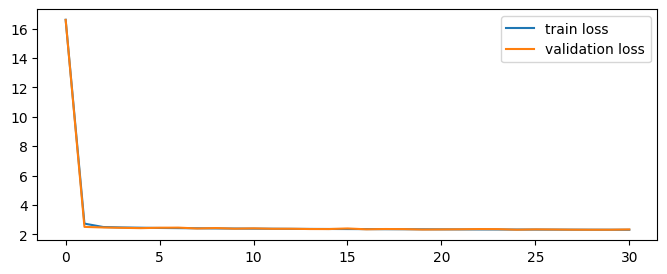

In [605]:
model = MLP(vocab_size, block_size, emb_size=2, hidden_size=128, device=device)
lr_provider = ConstatntLr(0.1)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=30, batch_size=64, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [606]:
for i in range(10):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

brashaha.
kaliledkael.
malise.
rema.
esour.
bian.
emela.
cem.
lun.
edynshlondree.


### Visualize 2D embeddings

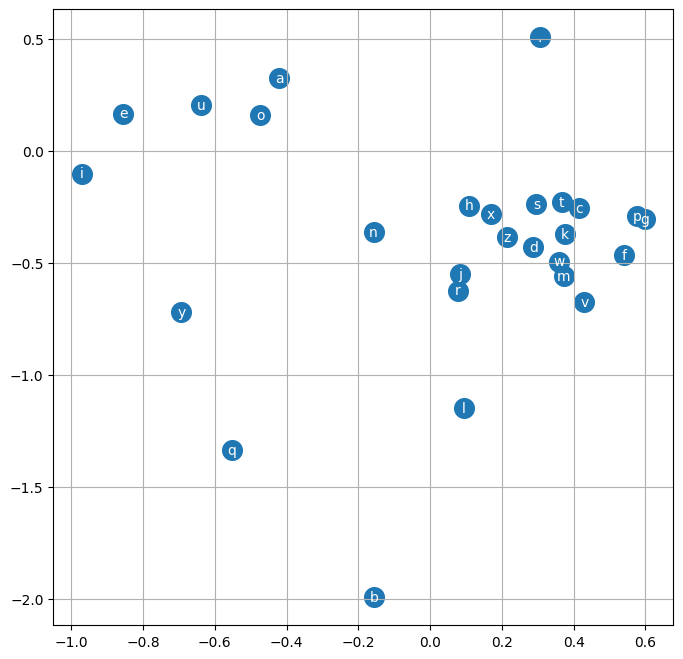

In [260]:
# visualize dimensions 0 and 1 of the embedding matrix model.emb for all characters
plt.figure(figsize=(8,8))
C = model.emb.cpu()
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Scale-up the model

model384.nelement()=22569
init_t_loss=32.68996047973633, init_v_loss=32.69854736328125
epoch=0: cur_avg_train_loss=4.583512243581528, cur_val_loss=3.46875
epoch=1: cur_avg_train_loss=2.9464479924918474, cur_val_loss=2.8033719062805176
epoch=2: cur_avg_train_loss=2.7702276403974944, cur_val_loss=2.653136730194092
epoch=3: cur_avg_train_loss=2.6801844118355453, cur_val_loss=2.676030158996582
epoch=4: cur_avg_train_loss=2.6287167299858534, cur_val_loss=2.7921688556671143
epoch=5: cur_avg_train_loss=2.584164727423112, cur_val_loss=2.612316608428955
epoch=6: cur_avg_train_loss=2.5521198845995285, cur_val_loss=2.5240797996520996
epoch=7: cur_avg_train_loss=2.530303592857254, cur_val_loss=2.5341737270355225
epoch=8: cur_avg_train_loss=2.5087114699041364, cur_val_loss=2.5292398929595947
epoch=9: cur_avg_train_loss=2.4942140157502504, cur_val_loss=2.7470767498016357
epoch=10: cur_avg_train_loss=2.4737029824699497, cur_val_loss=2.475613594055176
epoch=11: cur_avg_train_loss=2.4598292650566838, c

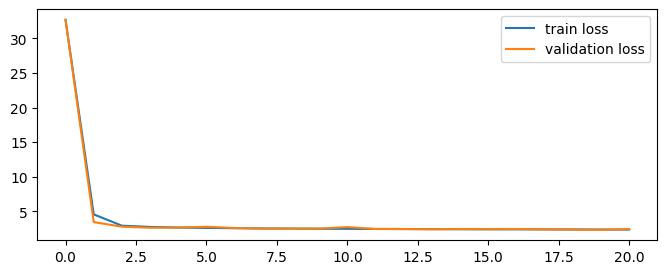

In [610]:
model384 = MLP(vocab_size, block_size, emb_size=10, hidden_size=384, device=device)
lr_provider = ConstatntLr(0.1)
optimizer   = SgdOptimizer(model384.parameters(), lr_provider)
print(f'{model384.nelement()=}')

init_t_loss = F.cross_entropy(model384(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model384(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")


t_loss, v_loss = train(model384, train_ds, val_ds, epoches=20, batch_size=64, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [608]:
for i in range(10):
    print(''.join(decode(evaluate(model384, max_new_tokens=1000))))

nzqxmbrmmrkmsrgbo.
nzqiwuciukahbwhmnhmrrknbbosm.
jnxmbrmmrkmsrg.
nzquuukwhzukknbbosm.
nzquuukwhbnhmrrknbbosm.
nzquuukwhbnhkbbuuukwhzukknbbosm.
nzqxmbrwuciukahbwhmlhqnkqrnv.
nzqxmbrwuciukaxbbuuukknbbosm.
nzquuukwhbnhkbbuuukwhzuuukwhbnhmrrknbbosm.
nzqxmbrmmrknbq.


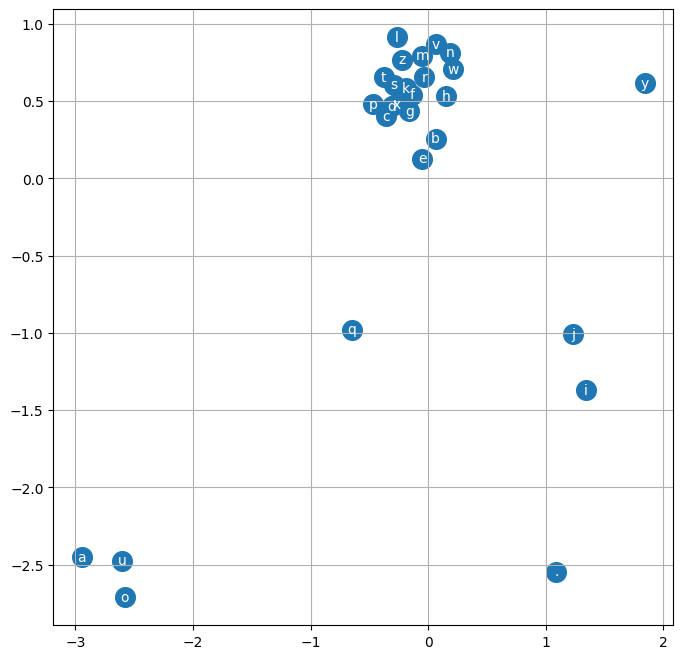

In [273]:
# visualize some 2 dimensions of the embedding matrix model384.emb for all characters
plt.figure(figsize=(8,8))
C = model384.emb.cpu()
dim1, dim2 = 4, 5
plt.scatter(C[:, dim1].data, C[:, dim2].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, dim1].item(), C[i, dim2].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

### Test evaluation

In [277]:
with torch.no_grad():
    test_logits = model384(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(test_loss)

tensor(2.5710)


### Build pyTorch-like model classes 

In [551]:
from functools import reduce

class Linear:
    def __init__(self, in_features, out_features, bias=True, device='cpu', dtype=torch.float32, gen=None):
        self.W = torch.randn([in_features, out_features], dtype=dtype, device=device, generator=gen)
        self.b = torch.randn(out_features, dtype=dtype, device=device, generator=gen) if bias else None

    def __call__(self, X):
        self.out = X @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out

    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def nelement(self):
        return sum(self.parameters())


class Tanh():
    def __call__(self, X):
        self.out = torch.tanh(X)
        return self.out

    def parameters(self):
        return []


class MultiLayerPerceptron:
    def __init__(self, vocab_size, block_size, n_emb, n_hidden, linear_layer=Linear, device='cpu', gen=None):
        self.context_size = n_emb * block_size
        self.emb_table = torch.randn((vocab_size, n_emb), device=device, generator=gen)
        self.layers = [
            linear_layer(self.context_size, n_hidden, device=device, gen=gen), Tanh(),
            linear_layer(n_hidden, n_hidden, device=device, gen=gen), Tanh(),
            linear_layer(n_hidden, n_hidden, device=device, gen=gen), Tanh(),
            linear_layer(n_hidden, n_hidden, device=device, gen=gen), Tanh(),
            linear_layer(n_hidden, vocab_size, device=device, gen=gen)
        ]
        for p in self.parameters():
            p.requires_grad = True

    def __call__(self, X):
        emb = self.emb_table[X].view(-1, self.context_size)
        return reduce(lambda out, L: L(out), self.layers, emb)

    def parameters(self):
        return [self.emb_table] + [p for layer in self.layers for p in layer.parameters()]

    def zero_grad(self):
        for p in self.parameters():
            p.grad = None

    def nelement(self):
        return sum(p.nelement() for p in self.parameters())

    def retain_grad(self):
        for L in self.layers:
            L.out.retain_grad()


### Activations visualizations

In [612]:
def plot_forward_activations(model, layer_type=None):
    plt.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layer_type):
            t = layer.out.to('cpu')
            saturation = (t.abs() > 0.97).float().mean()*100
            layer_name = layer.__class__.__name__
            print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer_name, t.mean(), t.std(), saturation))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('activation distribution')


def plot_backward_gradients(model, layer_type=None):
    plt.figure(figsize=(20, 4))
    legends = []
    for i, layer in enumerate(model.layers):
        if isinstance(layer, layer_type):
            t = layer.out.grad.to('cpu')
            layer_name = layer.__class__.__name__
            print('layer %d (%10s): mean %+f, std %e' % (i, layer_name, t.mean(), t.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i} ({layer.__class__.__name__}')
    plt.legend(legends);
    plt.title('gradient distribution')


def plot_weights_gradients(model):
    plt.figure(figsize=(20, 4))
    legends = []
    for i,p in enumerate(model.parameters()):
        t = p.grad.to('cpu')
        if p.ndim == 2:
            print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title('weights gradient distribution');


def plot_gradient_to_weight_ratio(optimizer):
    plt.figure(figsize=(20, 4))
    legends = []
    ud = optimizer.update_data_ratio
    for i,p in enumerate(optimizer.parameters):
        if p.ndim == 2:
            plt.plot([ud[j][i] for j in range(len(ud))])
            legends.append('param %d' % i)
    plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
    plt.legend(legends);

def plot_initialization_statistics(model, optimizer, train_ds, val_ds, device='cpu'):
    init_t_loss = F.cross_entropy(model(train_ds.X.to(device)), train_ds.y.to(device)).item()
    init_v_loss = F.cross_entropy(model(val_ds.X.to(device)), val_ds. y.to(device)).item()
    print(f"{init_t_loss=}, {init_v_loss=}")
    plot_forward_activations(model, layer_type=Tanh)
    mb_X, mb_y = train_ds.get_mini_batch(64, device)
    train_step(model, mb_X, mb_y, optimizer)
    plot_backward_gradients(model, Tanh)
    plot_weights_gradients(model)
    t_loss, v_loss = train(model, train_ds, val_ds, epoches=1, batch_size=182, optimizer=optimizer)
    plot_gradient_to_weight_ratio(optimizer)


model.nelement()=57257
init_t_loss=24.352346420288086, init_v_loss=24.18595314025879
layer 1 (      Tanh): mean +0.02, std 0.92, saturated: 67.68%
layer 3 (      Tanh): mean +0.00, std 0.96, saturated: 84.54%
layer 5 (      Tanh): mean -0.01, std 0.96, saturated: 84.05%
layer 7 (      Tanh): mean -0.01, std 0.96, saturated: 84.82%
layer 1 (      Tanh): mean +0.010100, std 3.210429e-01
layer 3 (      Tanh): mean -0.000151, std 1.282860e-01
layer 5 (      Tanh): mean -0.000765, std 4.817660e-02
layer 7 (      Tanh): mean +0.000327, std 2.034999e-02
weight   (27, 10) | mean -0.177626 | std 4.238103e+00 | grad:data ratio 4.206956e+00
weight  (30, 128) | mean -0.019062 | std 1.138505e+00 | grad:data ratio 1.154423e+00
weight (128, 128) | mean +0.000429 | std 3.270231e-01 | grad:data ratio 3.235153e-01
weight (128, 128) | mean +0.001514 | std 1.338918e-01 | grad:data ratio 1.331834e-01
weight (128, 128) | mean +0.000085 | std 4.425577e-02 | grad:data ratio 4.408982e-02
weight  (128, 27) | me

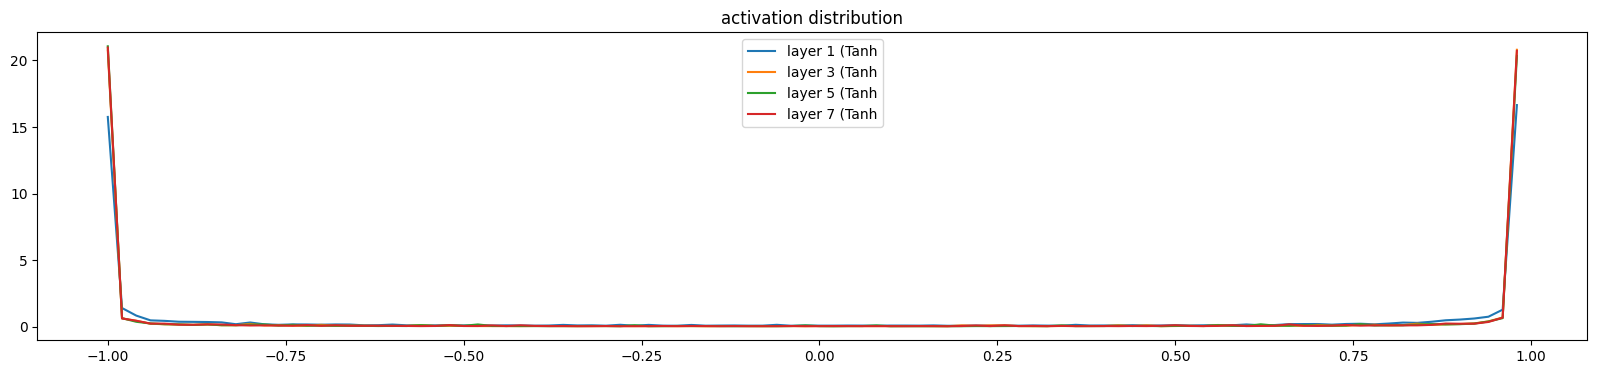

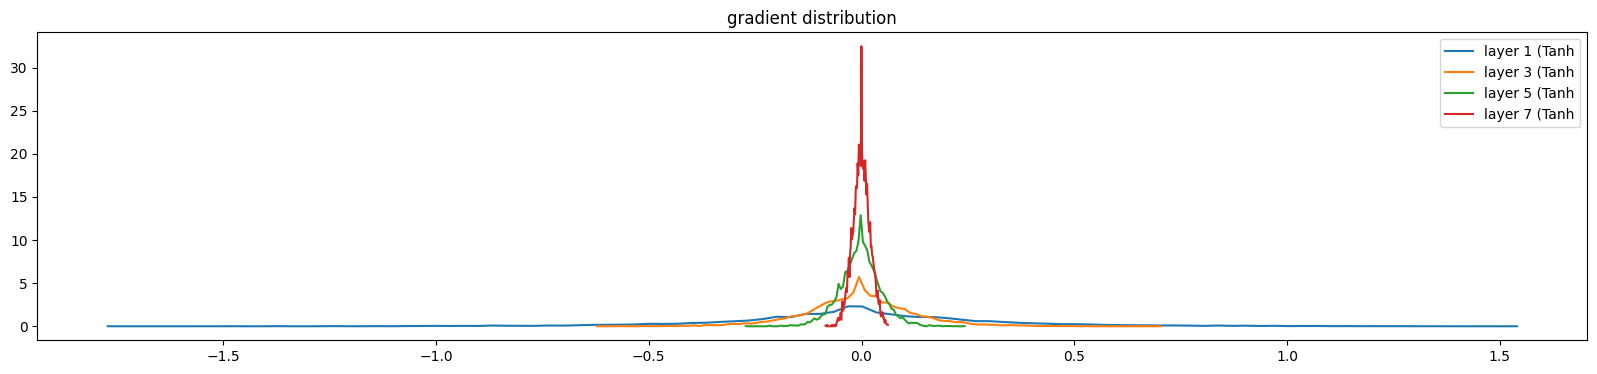

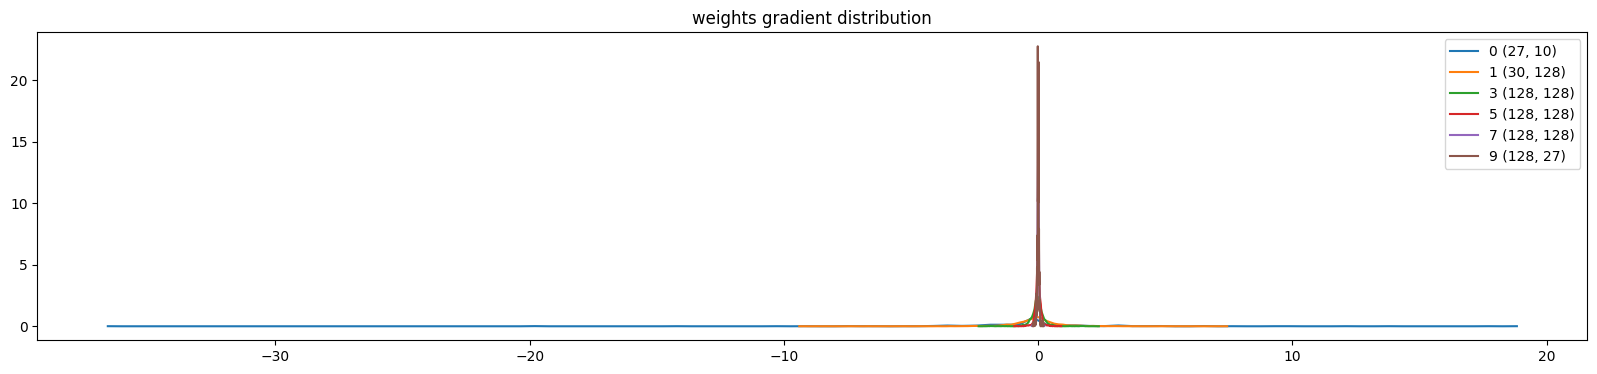

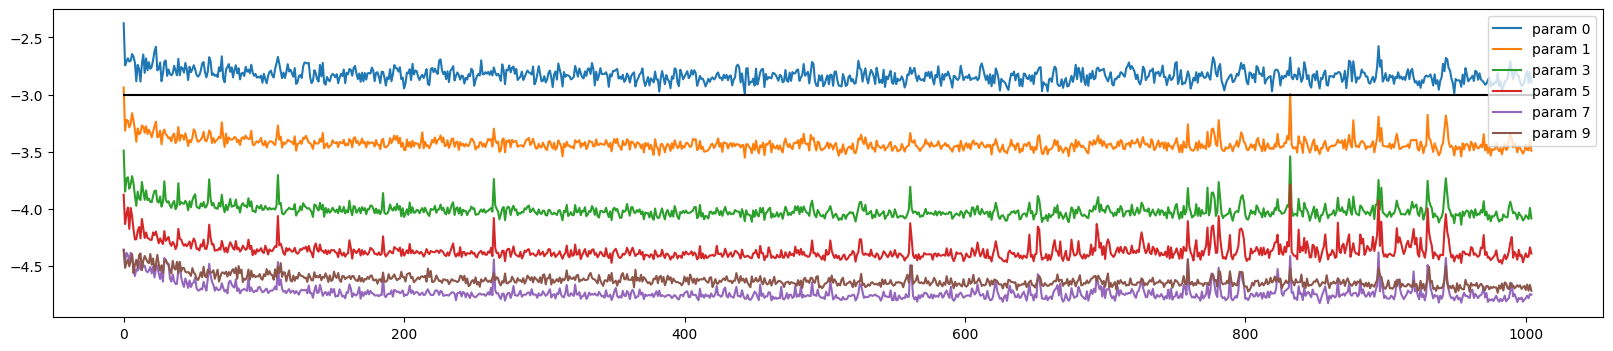

In [614]:
g = torch.Generator(device=device).manual_seed(7877)

model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- Given the plot above we see that randomly initialized weights produce almost saturated tanh activations, so gradient signal on backward pass will be to small to learn effectively.
- On the plot above we see the spreading of gradient distribution from last to very first layer (as a result of saturated tanh). It makes first layers difficult to learn as they get small gradient signal. It is called 'gradient vanishing'
- Weights gradients are not well distributed as well. Last layers have about 10 times bigger gradients, so they learn 10 times faster in the beginning
- Last plot represents update to weight ratio in logarithmic scale. This ratio represents "how big is the value we use to change weight comparing with weight itself". Good value for that ratio is approx -3. Current plot shows at least 4 last parameters which have 10000 times smaller update value in comparison to weight value.

### Final training of model w/o sophisticated initialization

model.nelement()=57257
init_t_loss=22.568626403808594, init_v_loss=22.515588760375977
epoch=0: cur_avg_train_loss=14.637721490100086, cur_val_loss=12.614884376525879
epoch=1: cur_avg_train_loss=11.839214324001297, cur_val_loss=11.17722225189209
epoch=2: cur_avg_train_loss=10.638765119461425, cur_val_loss=10.218816757202148
epoch=3: cur_avg_train_loss=9.864881590068103, cur_val_loss=9.594491958618164
epoch=4: cur_avg_train_loss=9.266403145049198, cur_val_loss=9.091633796691895
epoch=5: cur_avg_train_loss=8.790748193444484, cur_val_loss=8.697248458862305
epoch=6: cur_avg_train_loss=8.39066542999678, cur_val_loss=8.337068557739258
epoch=7: cur_avg_train_loss=8.054228100168752, cur_val_loss=8.041749000549316
epoch=8: cur_avg_train_loss=7.768019405494173, cur_val_loss=7.780548095703125
epoch=9: cur_avg_train_loss=7.513116058125439, cur_val_loss=7.555429935455322
epoch=10: cur_avg_train_loss=7.27597730140762, cur_val_loss=7.3158416748046875
epoch=11: cur_avg_train_loss=7.060804596460198, cur

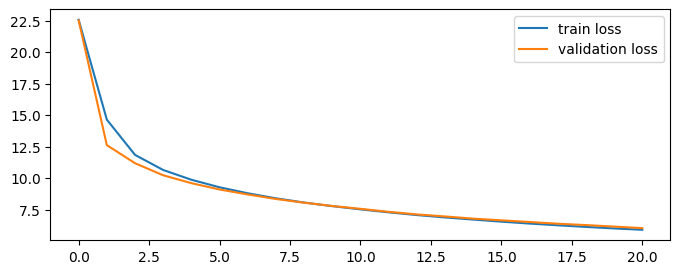

In [626]:
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [549]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))
    
with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'{test_loss=}')

dgkemarnnlnfoi.
namase.
.
ysexdvljmyjsfel.
jetithqihgfkxadmflwdylcn.
gvcgwsvizuzeyan.
ysremiasqtvhgnlqilnzy.
herar.
hana.
euynphyzutladr.
mamiexiecn.
jumeldovmoqieter.
janely.
gvcgwyjsfeldzutbnagj.
nan.


### Normalize weights in Linear layer

In [556]:
class LinearNormalized(Linear):
    def __init__(self, in_features, out_features, bias=True, device='cpu', dtype=torch.float32, gen=None):
        super().__init__(in_features, out_features, bias=bias, device=device, dtype=dtype, gen=gen)
        self.W /= in_features ** 0.5

model.nelement()=57257
init_t_loss=4.003686428070068, init_v_loss=4.0010480880737305
layer 1 (      Tanh): mean +0.07, std 0.70, saturated: 11.39%
layer 3 (      Tanh): mean -0.03, std 0.66, saturated: 8.46%
layer 5 (      Tanh): mean +0.05, std 0.68, saturated: 5.74%
layer 7 (      Tanh): mean -0.16, std 0.66, saturated: 6.49%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean +0.000003, std 3.573526e-04
layer 3 (      Tanh): mean -0.000014, std 5.602505e-04
layer 5 (      Tanh): mean -0.000022, std 8.694478e-04
layer 7 (      Tanh): mean +0.000007, std 1.344454e-03
weight   (27, 10) | mean -0.000084 | std 1.386261e-03 | grad:data ratio 1.376083e-03
weight  (30, 128) | mean -0.000011 | std 1.860849e-03 | grad:data ratio 1.033482e-02
weight (128, 128) | mean -0.000015 | std 3.582681e-03 | grad:data ratio 4.009864e-02
weight (128, 128) | mean +0.000024 | std 5.992488e-03 | grad:data ratio 6.743857e-02
weight (128, 128) | mean +0.000051 | std 1.125322e-02 | 

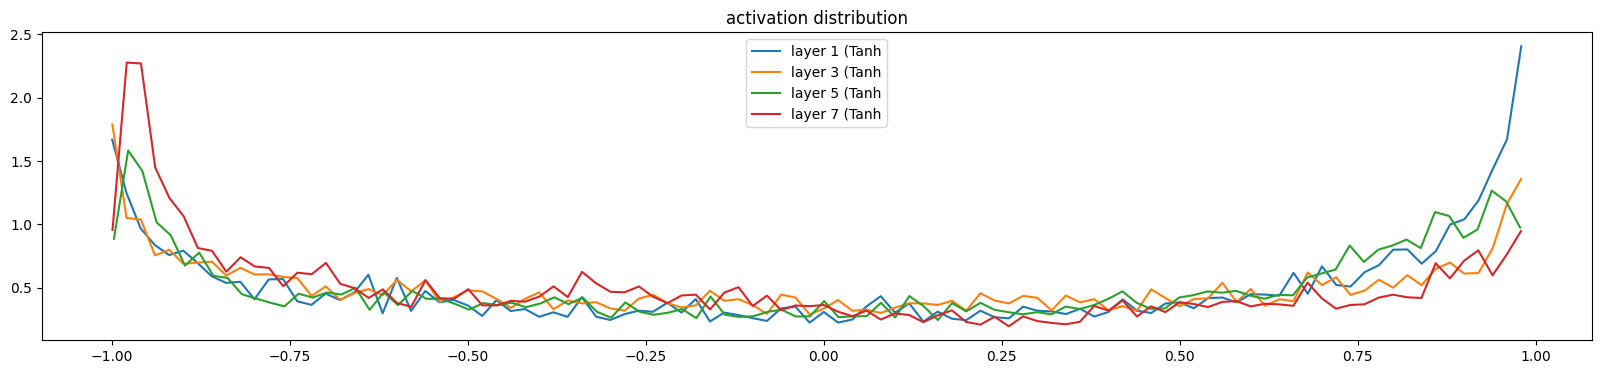

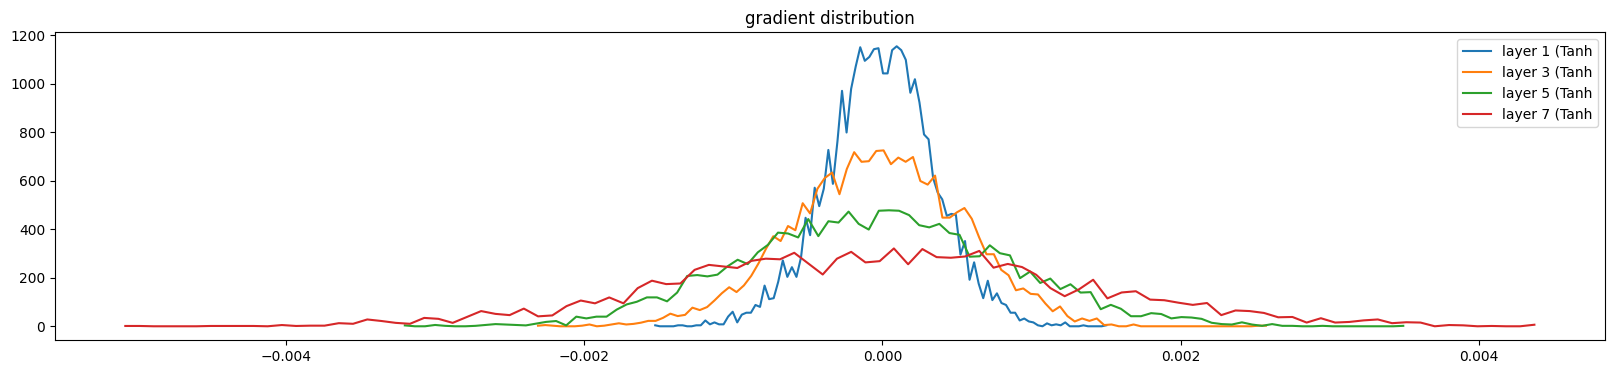

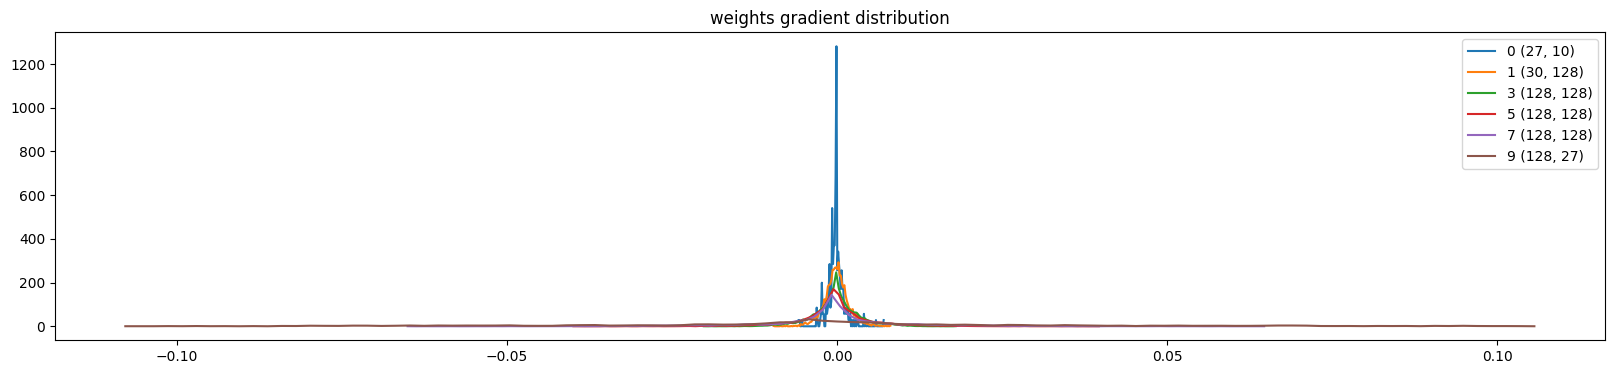

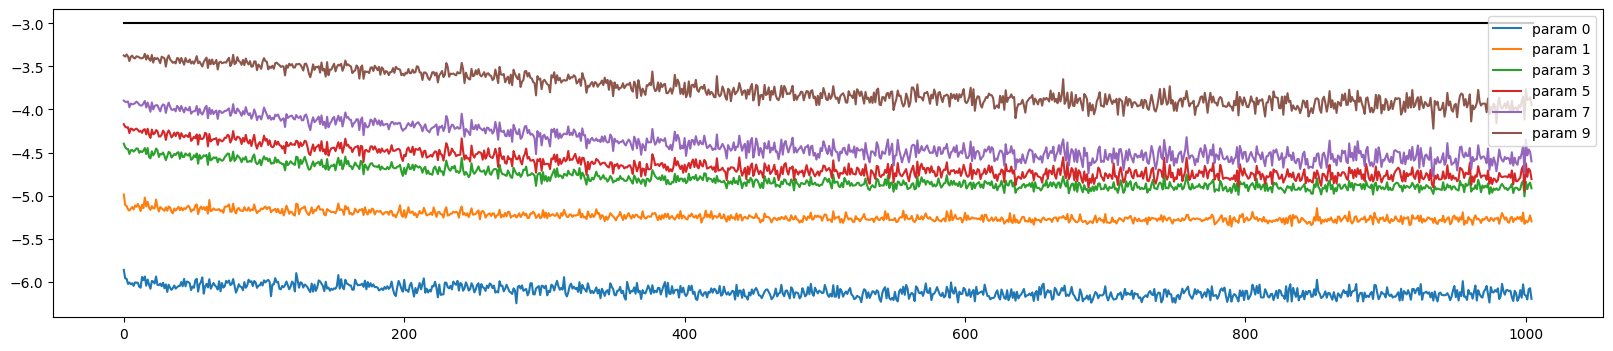

In [615]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")
plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- Now activations on tanh not so saturated as before normalization.
- Gradients become better at first layers
- Weights gradients are not well distributed still
- Update to weight ratio become worser. we need to apply more sophisticated initialization

model.nelement()=57257
init_t_loss=4.032634735107422, init_v_loss=4.033323287963867
epoch=0: cur_avg_train_loss=3.0001959560876825, cur_val_loss=2.817312240600586
epoch=1: cur_avg_train_loss=2.8023355869183026, cur_val_loss=2.779916524887085
epoch=2: cur_avg_train_loss=2.7733681634127856, cur_val_loss=2.7538580894470215
epoch=3: cur_avg_train_loss=2.747887885665514, cur_val_loss=2.7290022373199463
epoch=4: cur_avg_train_loss=2.7238869232485494, cur_val_loss=2.706005096435547
epoch=5: cur_avg_train_loss=2.701514785270767, cur_val_loss=2.684758186340332
epoch=6: cur_avg_train_loss=2.680646070446151, cur_val_loss=2.665173053741455
epoch=7: cur_avg_train_loss=2.6615627308290795, cur_val_loss=2.6474268436431885
epoch=8: cur_avg_train_loss=2.6443866959131097, cur_val_loss=2.631307601928711
epoch=9: cur_avg_train_loss=2.6290326712141, cur_val_loss=2.6173288822174072
epoch=10: cur_avg_train_loss=2.615314011792263, cur_val_loss=2.6046645641326904
epoch=11: cur_avg_train_loss=2.6028866193209037,

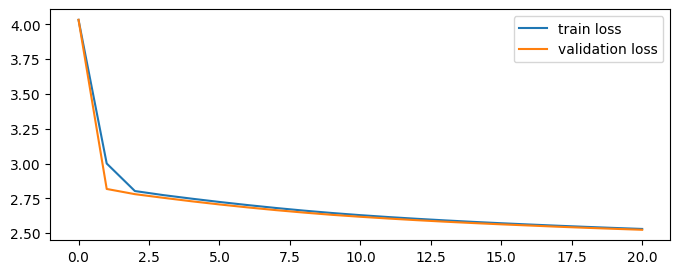

In [616]:
# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

#### After adding single initialization feature we see much better results in training 

In [617]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'{test_loss=}')

gy.
baysano.
lunaemeler.
karios.
lezhy.
sayseite.
anarrayasce.
naksdlina.
clboz.
arantayayyhosi.
asarnine.
ihryao.
nema.
aren.
aikedeg.
tensor(2.5336)


### Complete calculating the init scale (Kaiming init): adding gain
- for details: 'Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015)'
- concept: At initialization we want to maintain distribution of activations on each layer with same mean and std. Its is can be done by initialization of linear layer weights by sampling N(0,std^2) where std = gain/sqrt(in_features)

In [565]:
class LinearWithGain(LinearNormalized):
    def __init__(self, in_features, out_features, bias=True, device='cpu', dtype=torch.float32, gen=None):
        super().__init__(in_features, out_features, bias=bias, device=device, dtype=dtype, gen=gen)
        self.W *= 5/3 # a good gain value for tanh() activations

model.nelement()=57257
init_t_loss=4.405800819396973, init_v_loss=4.40297794342041
layer 1 (      Tanh): mean +0.05, std 0.77, saturated: 23.93%
layer 3 (      Tanh): mean -0.02, std 0.75, saturated: 19.46%
layer 5 (      Tanh): mean +0.02, std 0.74, saturated: 17.71%
layer 7 (      Tanh): mean -0.14, std 0.73, saturated: 17.86%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean -0.000012, std 1.982979e-03
layer 3 (      Tanh): mean +0.000004, std 2.086700e-03
layer 5 (      Tanh): mean -0.000026, std 2.200098e-03
layer 7 (      Tanh): mean -0.000020, std 2.288786e-03
weight   (27, 10) | mean -0.000899 | std 1.019129e-02 | grad:data ratio 1.011647e-02
weight  (30, 128) | mean -0.000082 | std 8.944890e-03 | grad:data ratio 2.980698e-02
weight (128, 128) | mean +0.000106 | std 9.654623e-03 | grad:data ratio 6.483477e-02
weight (128, 128) | mean +0.000029 | std 1.178958e-02 | grad:data ratio 7.960694e-02
weight (128, 128) | mean +0.000025 | std 1.500046e-02 |

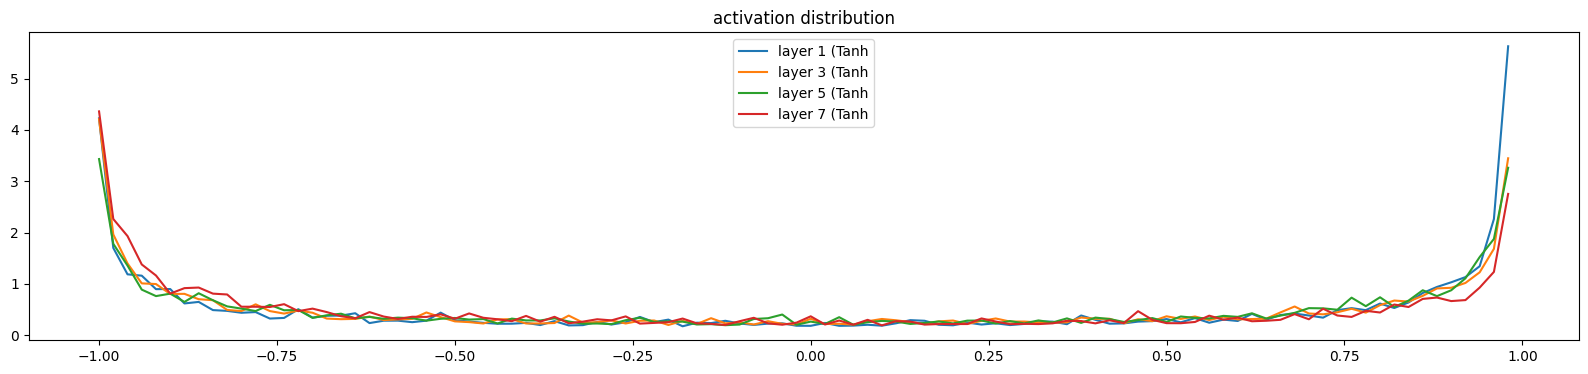

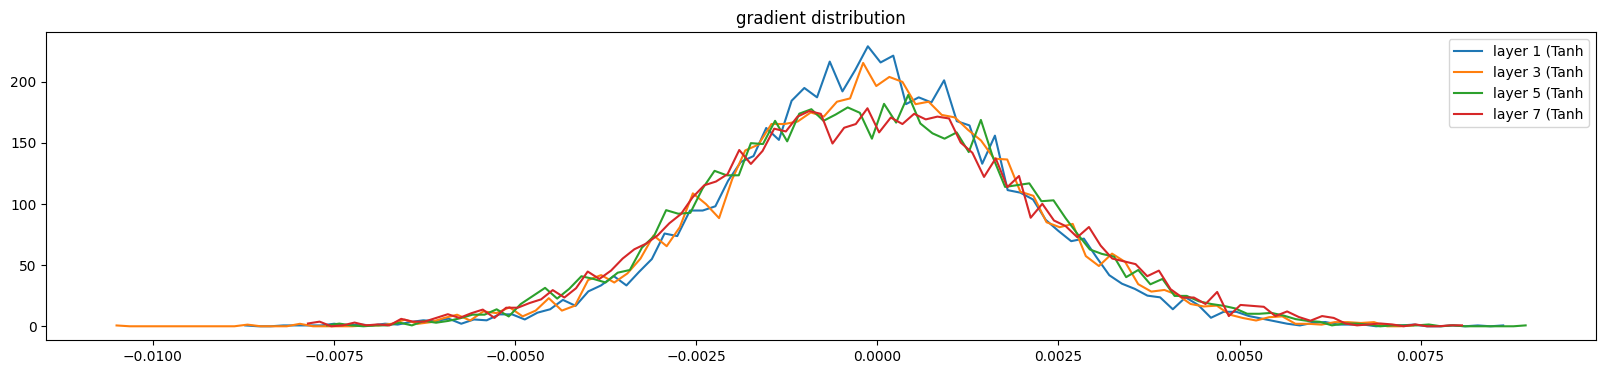

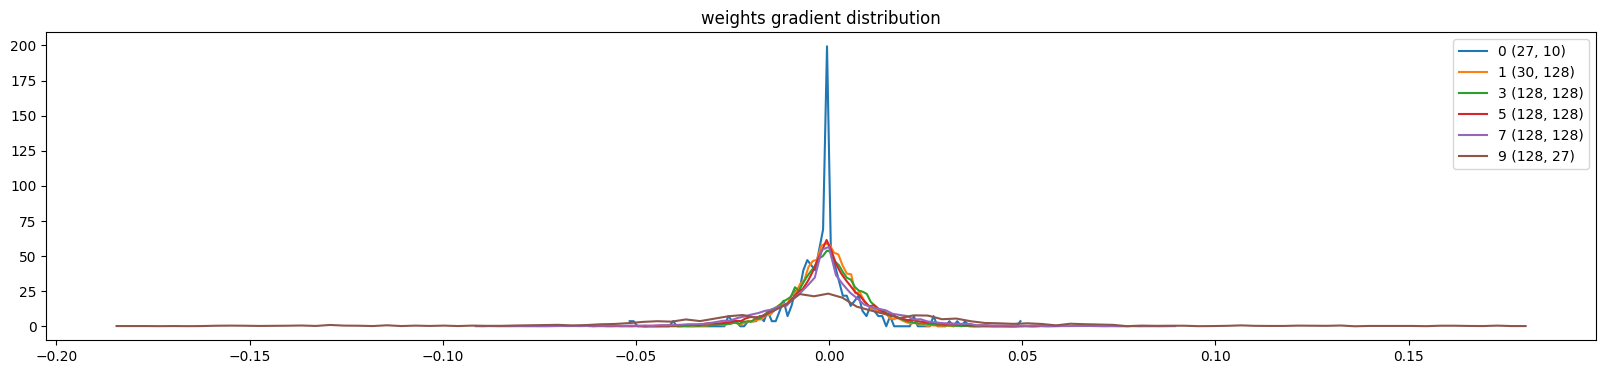

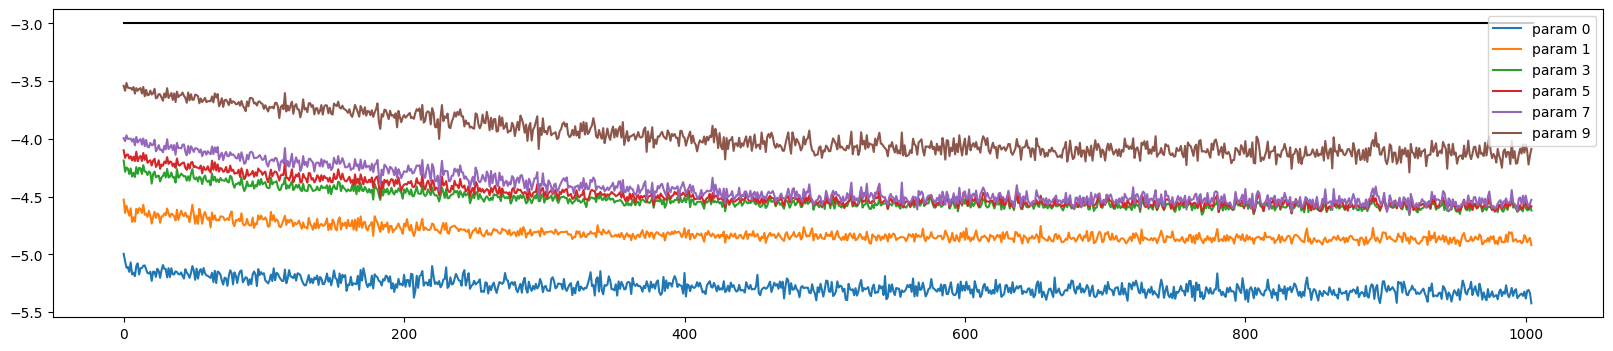

In [618]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearWithGain, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")
plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- Slightly hight satturation in the begining
- Gradients per layer distributed very well
- Weights gradients are good enougth
- We see that whatever the initialization feature we apply the update:weight ratio still not good enougth. That indicates that we should increase learining rate to make this ratio arrount -3

model.nelement()=57257
init_t_loss=3.638246536254883, init_v_loss=3.6383771896362305
epoch=0: cur_avg_train_loss=2.936609946874033, cur_val_loss=2.822794198989868
epoch=1: cur_avg_train_loss=2.806228617035535, cur_val_loss=2.782360792160034
epoch=2: cur_avg_train_loss=2.776269411423292, cur_val_loss=2.756878137588501
epoch=3: cur_avg_train_loss=2.7518465307604267, cur_val_loss=2.7332072257995605
epoch=4: cur_avg_train_loss=2.7288827879495354, cur_val_loss=2.7111027240753174
epoch=5: cur_avg_train_loss=2.7078431305657347, cur_val_loss=2.691418170928955
epoch=6: cur_avg_train_loss=2.688802225893712, cur_val_loss=2.673252582550049
epoch=7: cur_avg_train_loss=2.6714575490153645, cur_val_loss=2.656801223754883
epoch=8: cur_avg_train_loss=2.655594661891223, cur_val_loss=2.6419005393981934
epoch=9: cur_avg_train_loss=2.6410235629613656, cur_val_loss=2.6281630992889404
epoch=10: cur_avg_train_loss=2.627514292519406, cur_val_loss=2.6151692867279053
epoch=11: cur_avg_train_loss=2.614993987567871

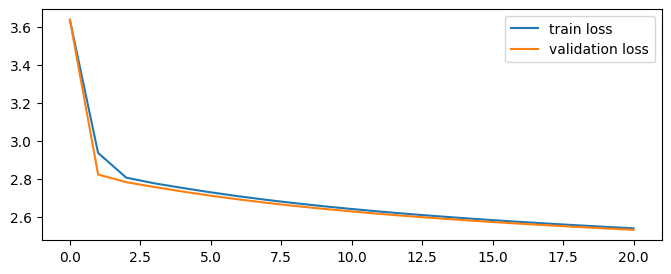

In [627]:
# Train model with normalized weights in linear layers
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(1e-3)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [628]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'{test_loss=}')

duc.
hhesxvt.
uya.
rearaideoandes.
amuceyni.
csise.
eyeyn.
rjhhnes.
aseta.
yeen.
jeanwytio.
haa.
eaneeiic.
biel.
rnwwh.
test_loss=tensor(2.5427)


- Slightly better results on test dataset and in training. Generated samples looks as bad as in previous model

### Increase learning rate

- given update:weight ratio plots we see that learning rate can be increased slightly to make update:weight = 1:1000
- according to last plot we can make a learning_rate for last model 10-100 times bigger

model.nelement()=57257
init_t_loss=4.405800819396973, init_v_loss=4.40297794342041
layer 1 (      Tanh): mean +0.05, std 0.77, saturated: 23.93%
layer 3 (      Tanh): mean -0.02, std 0.75, saturated: 19.46%
layer 5 (      Tanh): mean +0.02, std 0.74, saturated: 17.71%
layer 7 (      Tanh): mean -0.14, std 0.73, saturated: 17.86%
Warning. Current shuffle is processed. Reshuffling...
layer 1 (      Tanh): mean -0.000009, std 2.054209e-03
layer 3 (      Tanh): mean -0.000050, std 2.154877e-03
layer 5 (      Tanh): mean -0.000031, std 2.246329e-03
layer 7 (      Tanh): mean -0.000058, std 2.354570e-03
weight   (27, 10) | mean -0.000862 | std 1.389335e-02 | grad:data ratio 1.379082e-02
weight  (30, 128) | mean -0.000016 | std 1.007575e-02 | grad:data ratio 3.357404e-02
weight (128, 128) | mean -0.000067 | std 1.161521e-02 | grad:data ratio 7.800017e-02
weight (128, 128) | mean +0.000049 | std 1.363500e-02 | grad:data ratio 9.206958e-02
weight (128, 128) | mean -0.000024 | std 1.796292e-02 |

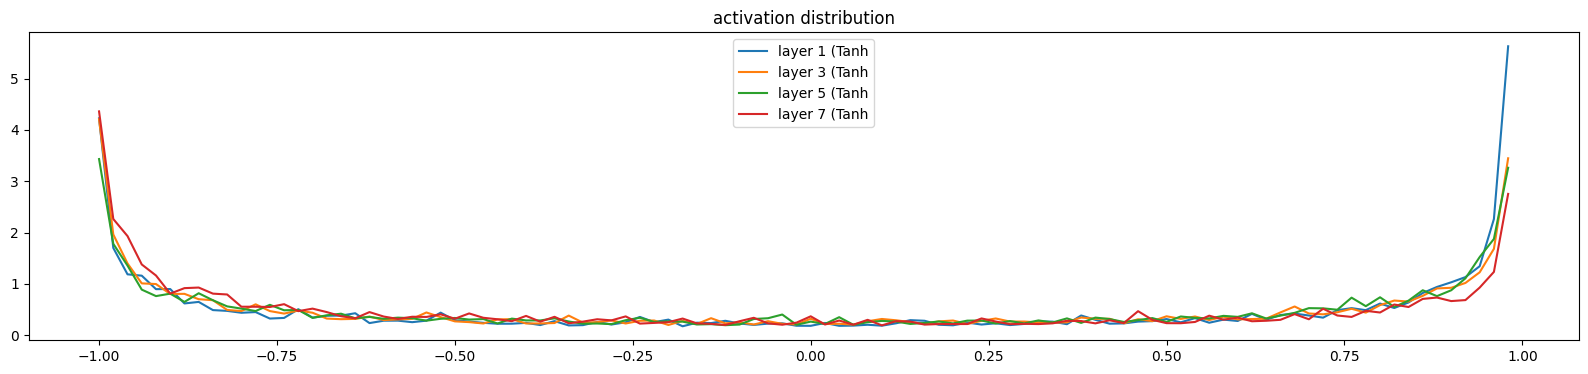

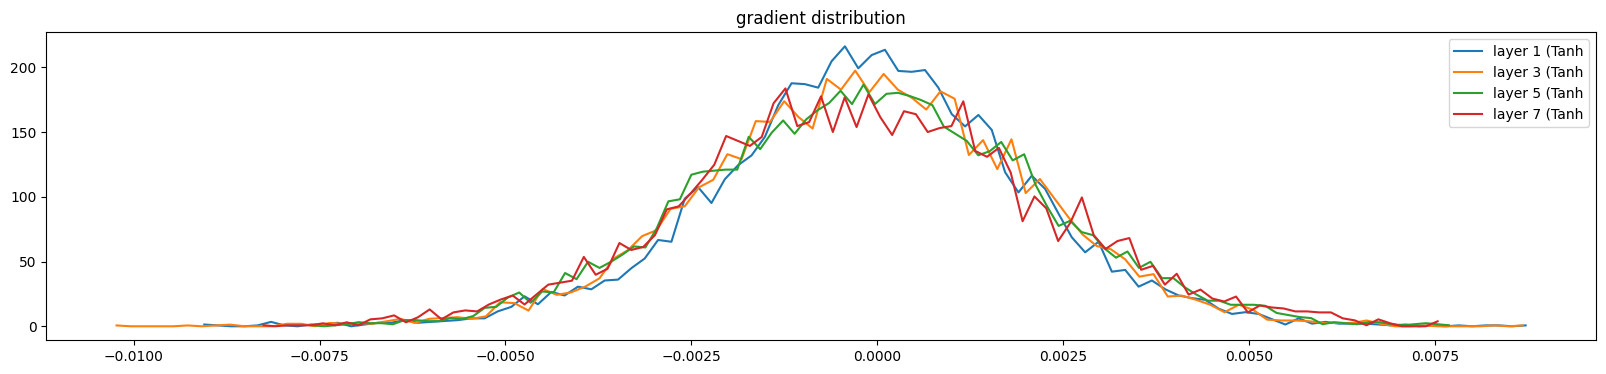

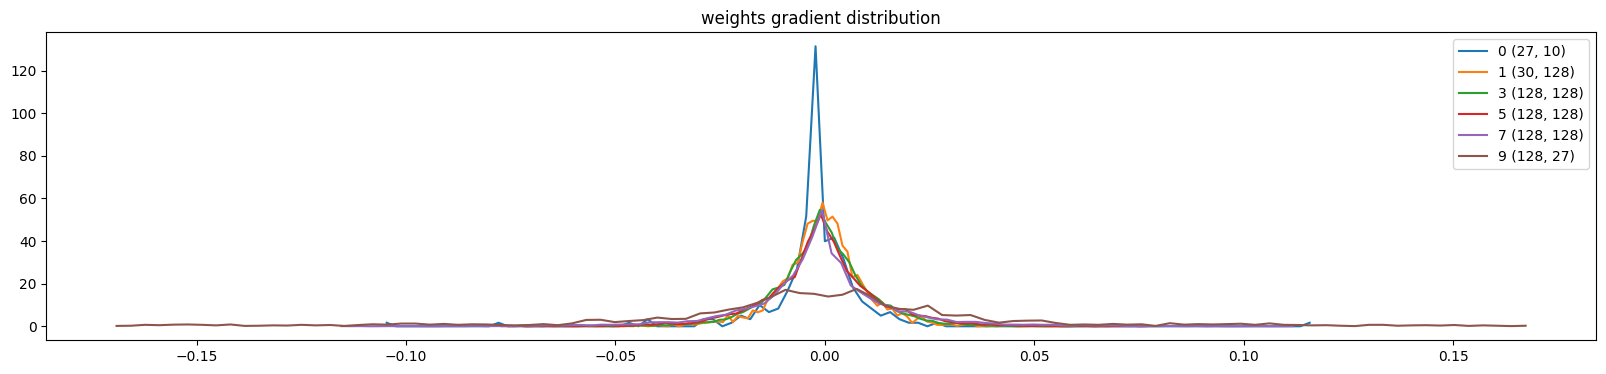

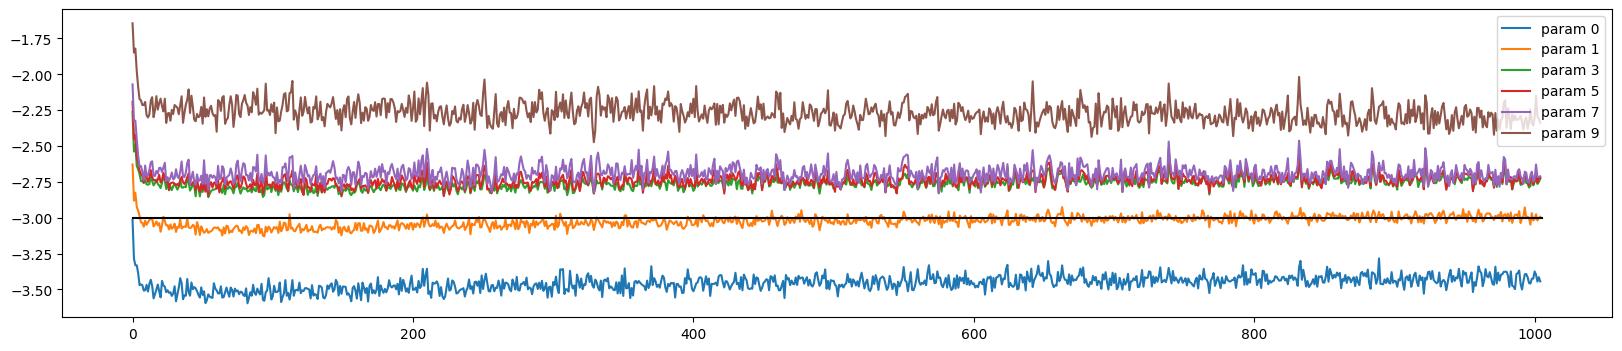

In [621]:
g = torch.Generator(device=device).manual_seed(7877)
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearWithGain, device=device, gen=g)
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

plot_initialization_statistics(model, optimizer, train_ds, val_ds, device=device)

- After few manual runs I found that 7e-2 Is a good one, so it 70 times bigger than previous value

model.nelement()=57257
init_t_loss=4.032634735107422, init_v_loss=4.033323287963867
epoch=0: cur_avg_train_loss=2.506293139372214, cur_val_loss=2.381453514099121
epoch=1: cur_avg_train_loss=2.330563562087329, cur_val_loss=2.309950590133667
epoch=2: cur_avg_train_loss=2.2756057220151225, cur_val_loss=2.255131244659424
epoch=3: cur_avg_train_loss=2.2432103919318, cur_val_loss=2.237247943878174
epoch=4: cur_avg_train_loss=2.220194621271346, cur_val_loss=2.234877109527588
epoch=5: cur_avg_train_loss=2.2013520579414063, cur_val_loss=2.2086002826690674
epoch=6: cur_avg_train_loss=2.186096720842726, cur_val_loss=2.19100022315979
epoch=7: cur_avg_train_loss=2.1729882792885085, cur_val_loss=2.1853785514831543
epoch=8: cur_avg_train_loss=2.1617129269349147, cur_val_loss=2.178187608718872
epoch=9: cur_avg_train_loss=2.1518075264307606, cur_val_loss=2.1810429096221924
epoch=10: cur_avg_train_loss=2.142414664486015, cur_val_loss=2.1565353870391846
epoch=11: cur_avg_train_loss=2.134367204401123, cur

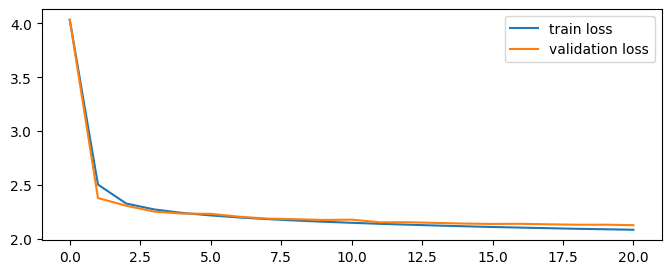

In [622]:
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearNormalized, device=device, gen=g)
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [623]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')

yas.
josoual.
mis.
luwan.
aes.
jenna.
kyrn.
lyli.
yas.
alyn.
shopalyden.
neycen.
mary.
yodine.
aard.

test_loss=tensor(2.1243)


- Last samples are nice, loss values are the best

### Decrease last layer weights to make initial prediction probability uniform

- Loss at the beginning may take 10-100 times bigger value than at other learning steps.
- We actually want to initialize our NN to the state so all classes are equally distibuted => logits are close to each other
- to achieve this we can decrease last layer weights and biases to small values

In [592]:
# in case of equaly distributed 27 classes (next token) we would expect 1/27 prob of each, so the loss is:
expected_initial_loss = -torch.tensor(1/27).log() # negative log likelihood
expected_initial_loss

tensor(3.2958)

model.nelement()=57257
init_t_loss=3.2955379486083984, init_v_loss=3.2954461574554443
epoch=0: cur_avg_train_loss=2.553280719247947, cur_val_loss=2.439309597015381
epoch=1: cur_avg_train_loss=2.3837566670193615, cur_val_loss=2.341093063354492
epoch=2: cur_avg_train_loss=2.3116520576743014, cur_val_loss=2.2909977436065674
epoch=3: cur_avg_train_loss=2.2711204508861225, cur_val_loss=2.260380506515503
epoch=4: cur_avg_train_loss=2.2427492215338933, cur_val_loss=2.250725030899048
epoch=5: cur_avg_train_loss=2.2211577604966335, cur_val_loss=2.2162342071533203
epoch=6: cur_avg_train_loss=2.2027280576438066, cur_val_loss=2.208317756652832
epoch=7: cur_avg_train_loss=2.1877091084106035, cur_val_loss=2.196446418762207
epoch=8: cur_avg_train_loss=2.1750661969422342, cur_val_loss=2.1816599369049072
epoch=9: cur_avg_train_loss=2.162834785136569, cur_val_loss=2.17714524269104
epoch=10: cur_avg_train_loss=2.15364594419164, cur_val_loss=2.1707472801208496
epoch=11: cur_avg_train_loss=2.14370781480078

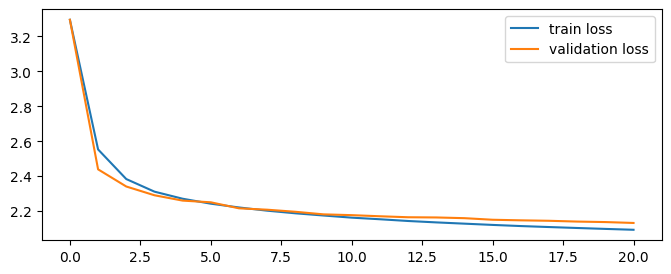

In [624]:
model = MultiLayerPerceptron(vocab_size, block_size, n_emb=10, n_hidden=128, linear_layer=LinearNormalized, device=device, gen=g)
last_linear = model.layers[-1]
with torch.no_grad():
    last_linear.W *= 0.01
    last_linear.b *= 0
lr_provider = ConstatntLr(7e-2)
optimizer   = SgdOptimizer(model.parameters(), lr_provider)
print(f"{model.nelement()=}")

init_t_loss = F.cross_entropy(model(train_X.to(device)), train_y.to(device)).item()
init_v_loss = F.cross_entropy(model(val_X.to(device)), val_y.to(device)).item()
print(f"{init_t_loss=}, {init_v_loss=}")

train_ds.reshuffle()
val_ds.reshuffle()
t_loss, v_loss = train(model, train_ds, val_ds, epoches=20, batch_size=182, optimizer=optimizer)
t_loss = [init_t_loss] + t_loss
v_loss = [init_v_loss] + v_loss

plt.figure(figsize=(8,3))
plt.plot(np.array(t_loss), label = 'train loss')
plt.plot(np.array(v_loss), label = 'validation loss')
plt.legend()

In [625]:
for i in range(15):
    print(''.join(decode(evaluate(model, max_new_tokens=1000))))

with torch.no_grad():
    test_logits = model(test_X).cpu()
    test_loss = F.cross_entropy(test_logits, test_y)
    print(f'\n{test_loss=}')

din.
tahikendelii.
dey.
richesa.
haron.
addanis.
ixzo.
ezia.
raysia.
gion.
emet.
auri.
aryn.
yat.
dimrenia.

test_loss=tensor(2.1340)
